# model training

LSTM

In [1]:
# add parent folder to search directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers, regularizers

/home/zhongyi/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
plt.rc('text', usetex=True)

In [4]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(None, 4), return_sequences=True))
# model.add(Dropout(.1))
model.add(Dense(64))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(.1))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam')


In [5]:
file = np.load('particle_results_organized/test2/cf_training.npz')

X, V, U, DUDt, Vm, L = file['X'], file['V'], file['U'], file['DUDt'], file['Vm'], file['L']
print(X.shape, V.shape, DUDt.shape)

(1000, 1500, 2) (1000, 1500, 2) (1000, 1500, 2)


In [6]:
features = np.concatenate((U, DUDt), axis=-1)    # concatenate with velocity vector
feat_mean, feat_std = np.mean(features, axis=(0,1)), np.std(features, axis=(0,1))

features = (features - feat_mean)/feat_std    # standardize input
print(feat_std)

# targets = V - Vm
targets = V - U

# split into training and testing sets
s = 2    # time-step
features_train, features_test = features[:800, ::2, :], features[800:, ::2, :]
targets_train, targets_test = targets[:800, ::2, :], targets[800:, ::2, :]

[  6.44338596   5.28999364 101.80008333 101.51854772]


In [7]:
model.load_weights('particle_results_organized/test2/weights/weights_800epochs_linear.h5')
# model.load_weights('particle_results_organized/test2/weights/weights_v-u_800epochs_relu.h5')

In [38]:
hist = model.fit(features_train, targets_train, batch_size=25, epochs=20,
         validation_data=(features_test, targets_test))


Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 33s 41ms/step - loss: 0.2400 - val_loss: 0.1266
Epoch 2/20
800/800 [==============================] - 30s 38ms/step - loss: 0.0845 - val_loss: 0.0834
Epoch 3/20
800/800 [==============================] - 30s 38ms/step - loss: 0.0645 - val_loss: 0.0743
Epoch 4/20
800/800 [==============================] - 30s 37ms/step - loss: 0.0603 - val_loss: 0.0712
Epoch 5/20
800/800 [==============================] - 30s 37ms/step - loss: 0.0580 - val_loss: 0.0689
Epoch 6/20
800/800 [==============================] - 30s 37ms/step - loss: 0.0569 - val_loss: 0.0667
Epoch 7/20
800/800 [==============================] - 30s 37ms/step - loss: 0.0559 - val_loss: 0.0666
Epoch 8/20
800/800 [==============================] - 30s 38ms/step - loss: 0.0540 - val_loss: 0.0640
Epoch 9/20
800/800 [==============================] - 29s 37ms/step - loss: 0.0529 - val_loss: 0.0626
Epoch 10/20
800/800 [===============

In [39]:
prediction_train = model.predict(features_train)
prediction_test = model.predict(features_test)

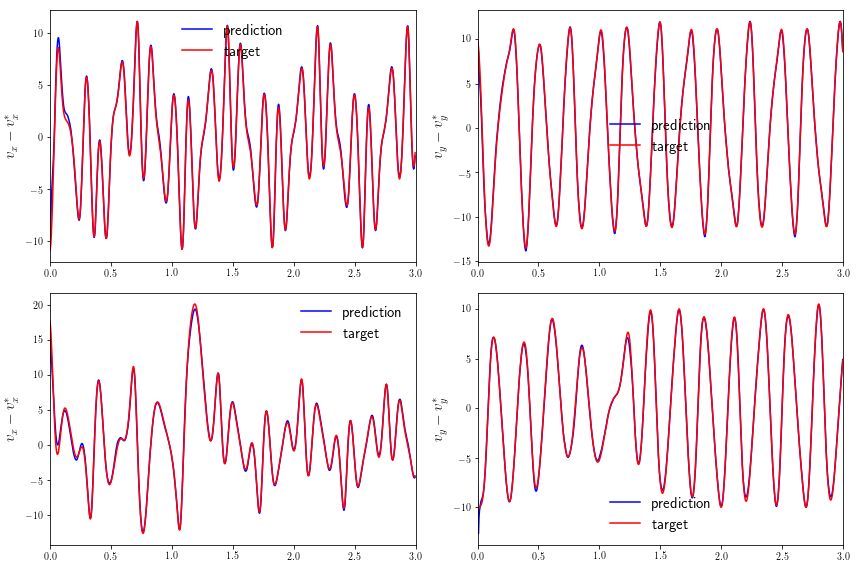

In [40]:
idx1, idx2 = 0, 118 
dim = 1
dt = 4e-3
tt = np.arange(prediction_train.shape[1])*dt

plt.rc('text', usetex=True)

# plot a training case
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0,0].plot(tt, prediction_train[idx1, :, 0], 'b-', label='prediction')
ax[0,0].plot(tt, targets_train[idx1, :, 0], 'r-', label='target')
ax[0,0].set_xlim([0, dt*prediction_train.shape[1]])
ax[0,0].legend(frameon=False, fontsize=15)
ax[0,0].set_ylabel('$v_x - v^*_x$', size=15)

ax[0,1].plot(tt, prediction_train[idx1, :, 1], 'b-', label='prediction')
ax[0,1].plot(tt, targets_train[idx1, :, 1], 'r-', label='target')
ax[0,1].set_xlim([0, dt*prediction_train.shape[1]])
ax[0,1].legend(frameon=False, fontsize=15)
ax[0,1].set_ylabel('$v_y - v^*_y$', size=15)

# plot a test case
ax[1,0].plot(tt, prediction_test[idx2, :, 0], 'b-', label='prediction')
ax[1,0].plot(tt, targets_test[idx2, :, 0], 'r-', label='target')
ax[1,0].set_xlim([0, dt*prediction_train.shape[1]])
ax[1,0].legend(frameon=False, fontsize=15)
ax[1,0].set_ylabel('$v_x - v^*_x$', size=15)

ax[1,1].plot(tt, prediction_test[idx2, :, 1], 'b-', label='prediction')
ax[1,1].plot(tt, targets_test[idx2, :, 1], 'r-', label='target')
ax[1,1].set_xlim([0, dt*prediction_train.shape[1]])
ax[1,1].legend(frameon=False, fontsize=15)
ax[1,1].set_ylabel('$v_y - v^*_y$', size=15)

plt.tight_layout()
plt.show()
# fig.savefig('test_cf_randABw.png', dpi=200)

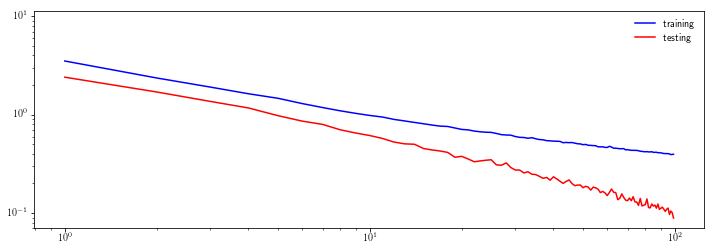

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.loglog(hist.history['loss'],'b-',label='training')
ax.loglog(hist.history['val_loss'],'r-',label='testing')
ax.legend(frameon=False)
plt.show()

In [44]:
model.save_weights('weights_v-u_800epochs_relu.h5')

# Validate on actual particle flow

In [8]:
testfile = np.load('particle_results_organized/test2/Velocities.npz')
V, U, DUDt, Vm = testfile['V'], testfile['U'], testfile['DUDt'], testfile['Vm']

V = np.swapaxes(V, 0, 1)
U = np.swapaxes(U, 0, 1)
DUDt = np.swapaxes(DUDt, 0, 1)
Vm = np.swapaxes(Vm, 0, 1)

print(V.shape, DUDt.shape)

(1000, 1200, 2) (1000, 1200, 2)


In [16]:
ss = 1
test = 1000

features = np.concatenate((U, DUDt), axis=-1)    # concatenate with velocity vector
features = (features - feat_mean)/feat_std
features = features[:test,::ss,:]
targets = V[:test,::ss,:] - Vm[:test,::ss,:]
# targets = V[:test,::ss,:] - U[:test,::ss,:]
print(features.shape)

prediction = model.predict(features)

(1000, 1200, 4)


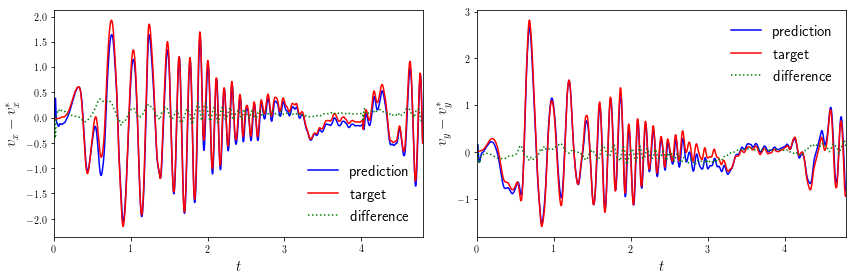

In [10]:
idx2 = 67
dt = 4e-3
tt = np.arange(prediction.shape[1])*dt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(tt, prediction[idx2, :, 0], 'b-', label='prediction')
ax[0].plot(tt, targets[idx2, :, 0], 'r-', label='target')
ax[0].plot(tt, targets[idx2, :, 0] - prediction[idx2, :, 0], 'g:', label='difference')
ax[0].set_xlim([0, dt*prediction.shape[1]])
ax[0].legend(frameon=False, fontsize=15)
ax[0].set_xlabel('$t$', size=15)
ax[0].set_ylabel('$v_x - v^*_x$', size=15)

ax[1].plot(tt, prediction[idx2, :, 1], 'b-', label='prediction')
ax[1].plot(tt, targets[idx2, :, 1], 'r-', label='target')
ax[1].plot(tt, prediction[idx2, :, 1] - targets[idx2, :, 1], 'g:', label='difference')
ax[1].set_xlim([0, dt*prediction.shape[1]])
ax[1].legend(frameon=False, fontsize=15)
ax[1].set_xlabel('$t$', size=15)
ax[1].set_ylabel('$v_y - v^*_y$', size=15)

plt.tight_layout()
# plt.savefig('ap_testcase.png', dpi=200)
plt.show()


Calculate a priori root mean squared errors

In [21]:
print(np.mean(np.sum((targets)**2,-1)))

9.882257736103556


In [11]:
rmse_rnn = np.mean(np.sum((targets - prediction)**2, axis=-1), axis=0)**.5
rmse_sm = np.mean(np.sum(targets**2, axis=-1), axis=0)**.5

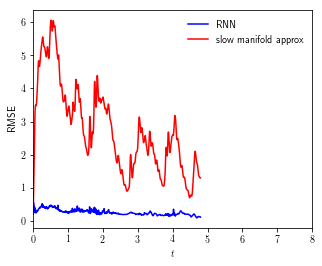

In [12]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(tt, rmse_rnn, 'b-', label='RNN')
ax.plot(tt, rmse_sm, 'r-', label='slow manifold approx')
ax.set_xlim([0, 8])
# ax.set_ylim([0, 6])
ax.set_xlabel('$t$')
ax.set_ylabel('RMSE')
ax.legend(frameon=False)
plt.savefig('rmse_ap.png', dpi=200)
plt.show()